# Introduction

Our project for course EECS 375/475 is a recommendation system, using supervised learning to determine what category of products a person will most likely buy. 

We used free dataset found on Kaggle at https://www.kaggle.com/mehdidag/black-friday. The data contains more than 500k transactions done on black friday by thousands of people, and includes details about them (age, gender, etc.), which we used as inputs. We needed to use a hot one encoder to convert these categorical inputs.

We decided to use 200k of the data for training and 200k for testing the model. As labels, we used the listed product category of each transactions.

To measure our precision we used "Success rate" instead of misclassifications. Success rate is the percentage of people who bought from the category our model recommended, while misclassifications is valued for each transaction and is therefore less accurate (see project video for additional details).

# Libraries and data loading

In [1]:
# import autograd / numpy necessities
%matplotlib inline
import matplotlib.pyplot as plt
from autograd import numpy as np
import pandas as pd
from autograd import grad
from tqdm import tqdm

# set path to datasets
datapath = 'datasets/'

# location of dataset. USE DATA PRE-SORTED BY USER_ID
csvname = datapath + 'BlackFriday_train.csv'
data = pd.read_csv(csvname).values.astype('str')
titles = pd.read_csv(csvname).columns.values.astype('str')

# One hot encoding

In [2]:
# replace given column containing K unique values, with K binary (1/-1) columns
def map_unique(data, titles, column):
    
    #create unique vals
    column_name = titles[column]
    unique_vals = np.unique(data[:,column])
    for unique_val in unique_vals:
        new_column = np.copy(data[:,column])
        new_column[new_column==unique_val] = '1'
        new_column[new_column!='1'] = '0'
        data = np.insert(data,column+1,new_column,axis = 1)
        titles = np.insert(titles,column+1,column_name + '_' + unique_val)
        
    #delete original column
    data = np.delete(data,column,axis = 1)
    titles = np.delete(titles,column)
    return data

In [3]:
cols_to_map = range (1,7)
for col_to_map in reversed(cols_to_map):
    data = map_unique(data, titles, col_to_map)

# Analysis using training data

In [4]:
# multiclass softmax
lam = 10**-5 # our regularization paramter
def multiclass_softmax(w):
    
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.log(np.sum(np.exp(all_evals), axis = 0))
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

# count how many costumers bought from the recommended category
def count_success_rate(w):
    decisions = np.argmax(model(x,w),axis = 0)
    user_ids = data[:,0:1].astype(np.float)
    users_num = len(np.unique(user_ids))
    categories_lst = []
    success = 0
    for i in range(P-1):
        if(user_ids[i+1] == user_ids[i]): # if it is the same costumer
            categories_lst.append(y[0][i])
        else: # if it is a different costumer
            if(decisions[i] in categories_lst):
                success += 1
            categories_lst = []
    return success / users_num * 100

# gradient descent function that also calculates misclassifications and success
def gradient_descent_with_mis_success(g,alpha,max_its,w):
    
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    cost_history = [g(w)] # cost function history container
    mis_history = []
    success_history = [count_success_rate(w)]
    for k in tqdm(range(max_its)):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        cost_history.append(g(w))
        
        #count and record misclassifications
        num_mis = 0
        decisions = np.argmax(model(x,w),axis=0)
        for i in range(P):
            if (y[0][i] != decisions[i]):
                num_mis += 1
        mis_history.append(num_mis / P * 100)

        #count and record success rate
        success_rate = count_success_rate(w)
        success_history.append(success_rate)
    return w,cost_history,mis_history,success_history

# cost function history plotter
def plot_cost_histories(cost_histories,txt):
    
    # create figure
    plt.figure()
    plt.title(txt + " over iterations")
    
    # loop over cost histories and plot each one
    for j in range(len(cost_histories)):
        history = cost_histories[j]
        plt.plot(history,label = txt)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# softmax cost
def softmax(w):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))

# linear model
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

100%|████████████████████████████████████████| 150/150 [04:14<00:00,  1.65s/it]


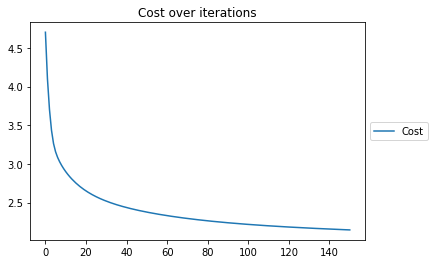

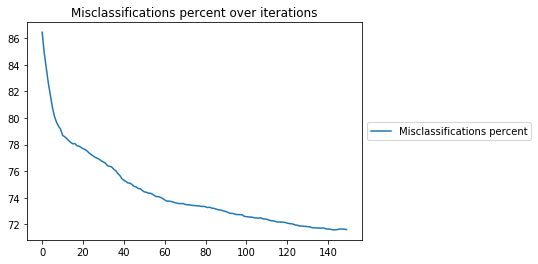

misclassifications percent before optimizing: 86.45
misclassifications percent after optimizing: 71.61


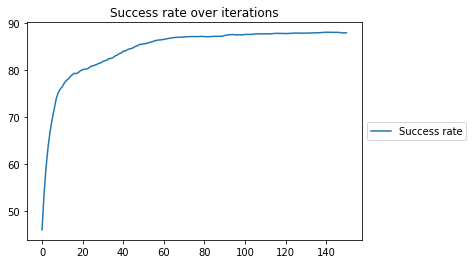

Success rate before optimizing: 45.99
Success rate after optimizing: 87.94


In [5]:
# get input/output
x = data[:,2:40].astype(np.float).T
y = data[:,41:42].astype(np.float).T - 1

# vars initialization
C = len(np.unique(y))
P = np.size(y)
N = len(x)
w = np.random.randn(N+1,C)
alpha = 1
cost_histories, mis_histories, success_histoies = [],[],[]
iterations = 150

# create histories
w, cost_history, mis_history, success_history = gradient_descent_with_mis_success(multiclass_softmax,alpha,iterations,w)
cost_histories.append(cost_history)
mis_histories.append(mis_history)
success_histoies.append(success_history)

# plot and print
plot_cost_histories(cost_histories, "Cost") 

plot_cost_histories(mis_histories, "Misclassifications percent")
print("misclassifications percent before optimizing: %.2f" %mis_histories[0][0])
print("misclassifications percent after optimizing: %.2f" %mis_histories[0][-1])

plot_cost_histories(success_histoies, "Success rate")
print("Success rate before optimizing: %.2f" %success_histoies[0][0])
print("Success rate after optimizing: %.2f" %success_histoies[0][-1])

# Count success rate over testing data

In [6]:
csvname = datapath + 'BlackFriday_test.csv'
data = pd.read_csv(csvname).values.astype('str')

for col_to_map in reversed(cols_to_map):
    data = map_unique(data, titles, col_to_map)

# get input/output
x = data[:,2:40].astype(np.float).T
y = data[:,41:42].astype(np.float).T - 1

print("Success rate after optimizing: %.2f" %count_success_rate(w))

Success rate after optimizing: 88.22
